In [11]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np

check_sum_length = 5

# n_samples / sample_rate = duration in seconds
def create_sin_wave(freq, n_samples=44100, sample_rate=44100, amplitude=10000,
        save_to_file=None, graph=True):
    x = np.arange(n_samples)
    y = amplitude * np.sin(2 * np.pi * freq * x / sample_rate)
    if graph:
        plt.plot(y)
        plt.xlim(0, 512)
    if save_to_file is not None:
        output_array = y.astype(np.int16)
        wavfile.write(save_to_file, sample_rate, output_array)
    else:
        return y.astype(np.int16)

def get_signal(data_seq, sample_size=1024, write_to_file=None):
    tot_signal = list()
    for i in data_seq:
        if i == 0:
            signal = create_sin_wave(18 * 1000, n_samples=1024, graph=False)
        else:
            signal = create_sin_wave(19 * 1000, n_samples=1024, graph=False)
        tot_signal.extend(signal)
    print('generated signal of length {}'.format(len(tot_signal)))
    if write_to_file is not None:
        wavfile.write(write_to_file, 44100, np.array(tot_signal))
    return np.array(tot_signal).astype(np.int16)

# if output_length > music: the resulting signal conforms to music_length
# if output_length > data_signal: data_signal will be repeated to fit output_length
# all units here are in terms of number of samples points
def mix_with_music(data_signal, music_name, output_length=2*44100,    # use output_length of -1 for no trimming
                   # Note that 1024 * 5 means we will wait for 5 FFT intervals before
                   # attempting to transmit the next data sequence
                   start_delay=1024 * 5,
                   to_mono=True, graph=False,write_to_file=None):
    # 1. Extract Music Signals
    fs, data =  wavfile.read(music_name)
    if output_length == -1:
        output_length = len(data)
    music_signal = data[:output_length]
    if to_mono:
        music_signal = np.mean(music_signal, axis=1).astype(np.int16)

    # 2. Repeat + Pad Data Signals
    # if we can't fit data into music for kth time, it's ok to leave it as k - 1
    repeat_num = int(np.floor(output_length / (start_delay + len(data_signal))))
    # use music signal as base
    expanded_data_signal = []
    print('output repeates data signal {} times ({:.3f})'.format(repeat_num, output_length / (start_delay + len(data_signal))))
    for _ in range(repeat_num):
        expanded_data_signal.extend(list(np.zeros(start_delay, dtype=np.int16)))
        expanded_data_signal.extend(data_signal)
    # add zero paddings to match size of data and music
    while len(expanded_data_signal) < output_length:
        expanded_data_signal.append(0)

    # 3. Data + Music
    new_signal = np.array(expanded_data_signal, dtype=np.int16) + music_signal

    if write_to_file is not None:
        wavfile.write(write_to_file, 44100, new_signal)

    if graph:
        plt.subplot(1, 2, 1)
        plt.plot(music_signal)
        plt.title('before')
        plt.subplot(1, 2, 2)
        plt.plot(new_signal)
        plt.title('after')
        plt.tight_layout()

    return new_signal

def binary2int(binary_array):
    binary_string = ''
    for i in binary_array:
        binary_string += str(i)
    return int(binary_string, 2)

def binary_array2string(binary_array):
    binary_string = ''
    for i in binary_array:
        binary_string += str(i)
    return binary_string

## Step I: Constant Wave ultrasound

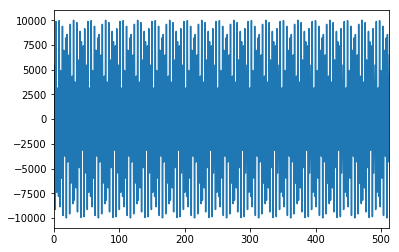

In [18]:
create_sin_wave(18000, save_to_file='const_18k.wav')

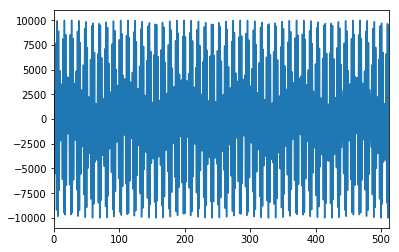

In [19]:
create_sin_wave(20* 1000, save_to_file='const_20k.wav')

## BFSK: Binary Frequency Shift Keying

In [20]:
44100 / 1024

43.06640625

In [21]:
data_seq = [0, 1] * 22
print(data_seq)

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


In [41]:
tot_signal = list()
for i in data_seq:
    if i == 0:
        signal = create_sin_wave(18 * 1000, n_samples=1024, graph=False)
    else:
        signal = create_sin_wave(19 * 1000, n_samples=1024, graph=False)
    tot_signal.extend(signal)
print(len(tot_signal))
wavfile.write('output/interchanging_18_19.wav', 44100, np.array(tot_signal))

45056


## Mix with Music!

In [42]:
input_file = "original_songs/Scarborough-Fair.wav"
fs, data =  wavfile.read(input_file)
data_2_sec = data[:(sample_rate * 2)]
mono_data_2_sec = np.mean(data_2_sec, axis=1).astype(np.int16)
print(mono_data_2_sec.shape)
print(mono_data_2_sec)

(88200,)
[-148 -311 -292 ... 3141 3614 3995]


In [43]:
new_signal = []
for idx, i in enumerate(mono_data_2_sec):
    new_signal.append(i + tot_signal[idx % len(tot_signal)])
print(len(new_signal))

88200


In [44]:
wavfile.write('output/mixed_18_19.wav', 44100, np.array(new_signal))

## Actual Signal!!

In [24]:
curr_signal = np.random.choice([0, 1], 26)
curr_signal

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0])

In [3]:
preamble = [0, 1, 0, 1, 1, 0]
curr_data = [0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
# building checksum
#                                    # skipping 0b
check_sum = [int(i) for i in bin(np.sum(curr_data))[2:]]
# 0 padding
while len(check_sum) < check_sum_length:
    check_sum.insert(0, 0)

all_data = preamble + curr_data + check_sum
print('all data')
print('preamble', preamble)
print('check sum', check_sum)
print('curr data', curr_data)
print('song signature: ', binary_array2string(curr_data))

full_data_signal = get_signal(all_data)

all data
preamble [0, 1, 0, 1, 1, 0]
check sum [0, 1, 1, 0, 0]
curr data [0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
song signature:  01001101110100011001010010
generated signal of length 37888


output repeates data signal 241 times (241.603)


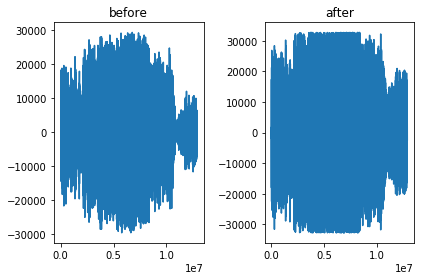

In [22]:
song_name = "original_songs/Scarborough-Fair.wav"
all_signal = mix_with_music(full_data_signal, song_name, output_length=-1, start_delay=1024 * 15,
                            graph=True, write_to_file='output/scarborough_fair_embedded.wav')

In [13]:
print(np.sum([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]))
binary2int(check_sum)

12


12

output repeates data signal 1 times (1.000)


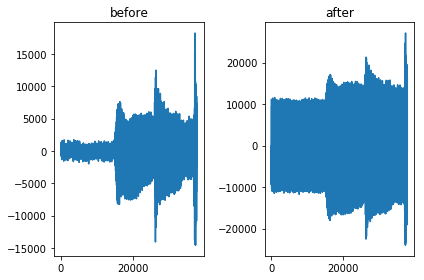

In [13]:
song_name = "original_songs/Scarborough-Fair.wav"
all_signal = mix_with_music(full_data_signal, song_name, output_length=37888, start_delay=0,
                            graph=True)
plt.savefig('eval_result/encode.png')